In [1]:
import pandas as pd
import numpy as np
from openclean.data.load import dataset
from openclean.pipeline import stream
from openclean.cluster.knn import knn_clusters, knn_collision_clusters
from openclean.function.similarity.base import SimilarityConstraint
from openclean.function.similarity.text import LevenshteinDistance
from openclean.function.value.threshold import GreaterThan
from openclean.function.value.null import is_empty
from openclean.operator.transform.update import update
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
pd.set_option('display.max_rows', None)

root = '../Dataset/'

files = [
    'Local_Law_8_of_2020___Complaints_of_Illegal_Parking_of_Vehicles_Operated_on_Behalf_of_the_City.csv',
    'DOB_NOW__Electrical_Permit_Applications.csv',
    'DOB_Cellular_Antenna_Filings.csv'
]


#Data column of City in different files
columns = [
    'City', 
    'CITY',
    'City'
]

# Current Profile

In [3]:
# add all city columns to one dataframe, then generate the data profile
df = pd.DataFrame(columns=['CITY'])
for file in files:
    path = root + file
    ds = dataset(path, encoding='utf-8')
    print("Loading... ", file)
    # rename all cols to CITY
    ds.rename(columns={'City': 'CITY'}, inplace=True)
    city = ds[['CITY']]
    df = df.append(city)
print(df.value_counts())

Loading...  Local_Law_8_of_2020___Complaints_of_Illegal_Parking_of_Vehicles_Operated_on_Behalf_of_the_City.csv
Loading...  DOB_NOW__Electrical_Permit_Applications.csv
Loading...  DOB_Cellular_Antenna_Filings.csv
CITY               
BROOKLYN               83935
NEW YORK               32192
STATEN ISLAND          28649
BRONX                  25130
LONG ISLAND CITY       17870
FLUSHING               11844
ASTORIA                 9343
WOODSIDE                7635
JAMAICA                 5105
MASPETH                 4206
OZONE PARK              4046
SPRINGFIELD GARDENS     3495
RICHMOND HILL           2934
COLLEGE POINT           2597
QUEENS VILLAGE          2406
QUEENS                  2263
ST. ALBANS              2228
L.I.C.                  2104
WOODHAVEN               2101
NEW YORK                1497
MIDDLE VILLAGE          1486
RIDGEWOOD               1482
WHITESTONE              1361
PARSIPPANY              1196
                        1147
EAST ELMHURST           1037
FAR ROCKAWAY  

# Apply Original Method

In [4]:
# For our original method, we firstly use value_counts method to check if there is any empty value, then we repleace them with 'UNKNOWN'. 
# Then we make all the values in this column uppercase
def getNoneIdx(df, column):
    res = set()
    idx = 0
    for name in df[column]:
        if name is None or (len(name) == 0):
            res.add(idx)
        idx += 1
    return res

def original_cleaning_method(df, column):
    mask = df[column] != df[column].str.upper()
    upper_rows_index = set(df.loc[mask].index.to_list())
    df = update(df, columns=column, func=str.upper)
    empty_rows_index = getNoneIdx(df, column)
    df = update(df, columns=column, func=lambda x: 'UNKNOWN' if is_empty(x) else x)
    affected_count = len(upper_rows_index.union(empty_rows_index))
    return df, affected_count

def calc_precision_recall(remain_problems_rows_count, cleaned_rows_count):
    total = remain_problems_rows_count + cleaned_rows_count
    precision = (cleaned_rows_count - remain_problems_rows_count) / cleaned_rows_count if cleaned_rows_count != 0 else 0.0
    recall = (cleaned_rows_count - remain_problems_rows_count) / total if total != 0 else 0.0
    print(f'The precision value should be {precision} and the recall value should be {recall}')

(df_original_clean, count) = original_cleaning_method(df, 'CITY')

In [5]:
print(count)

1147


In [6]:
df_original_clean['CITY'].value_counts()

BROOKLYN               83935
NEW YORK               32192
STATEN ISLAND          28649
BRONX                  25130
LONG ISLAND CITY       17870
FLUSHING               11844
ASTORIA                 9343
WOODSIDE                7635
JAMAICA                 5105
MASPETH                 4206
OZONE PARK              4046
SPRINGFIELD GARDENS     3495
RICHMOND HILL           2934
COLLEGE POINT           2597
QUEENS VILLAGE          2406
QUEENS                  2263
ST. ALBANS              2228
L.I.C.                  2104
WOODHAVEN               2101
NEW YORK                1497
MIDDLE VILLAGE          1486
RIDGEWOOD               1482
WHITESTONE              1361
PARSIPPANY              1196
UNKNOWN                 1147
EAST ELMHURST           1037
FAR ROCKAWAY            1034
FRESH MEADOWS           1019
ROCKAWAY PARK           1002
GLENDALE                 826
JACKSON HEIGHTS          786
BAYSIDE                  780
BROOKLYN                 739
SOUTH OZONE PARK         625
SOUTH RICHMOND

In [7]:
# Calculate the precision and call of the original method
# Based on the result of value_counts, we found that the total number of question rows should be 48234
# the number of question rows that have been modified is 1147, and the number of rows which still contain problems is 47087
calc_precision_recall(48234, count)

The precision value should be -41.05231037489102 and the recall value should be -0.9535448856847776


In [8]:
# Save the reference data
df.to_csv('../Reference Data/original_version_city.csv', index=None)
df_original_clean.to_csv('../Reference Data/original_method_city.csv', index=None)

# Apply refined method

In [9]:
# Perform KNN to detect spelling errors
df = stream('../Reference Data/original_version_city.csv')
def print_cluster(cnumber, cluster):
    print('Cluster {} (of size {})\n'.format(cnumber, len(cluster)))
    for val, count in cluster.items():
        print('{} ({})'.format(val, count))
    print('\nSuggested value: {}\n\n'.format(cluster.suggestion()))
    
# Minimum cluster size. Use ten as default (to limit
# the number of clusters that are printed in the next cell).
def run_knn(df, column, t=0.8, minsize = 2):
    dba = df.select(column).distinct()
    clusters = knn_clusters(
        values=dba,
        sim=SimilarityConstraint(func=LevenshteinDistance(), pred=GreaterThan(t)),
        minsize=minsize
    )
    print('{} clusters of size {} or greater'.format(len(clusters), minsize))
    # Sort clusters by decreasing number of distinct values.
    clusters.sort(key=lambda c: len(c), reverse=True)
    for i, cluster in enumerate(clusters):
        print_cluster(i + 1, cluster)
    return clusters

clusters = run_knn(df, 'CITY')

60 clusters of size 2 or greater
Cluster 1 (of size 9)

NEW YORK,       (8)
NEW YORKER      (1)
NEW YORL        (1)
 NEW YORK       (1)
BEW YORK        (1)
MEW YORK        (1)
NEW YOEK        (1)
NEW  YORK       (6)
NEW YORK        (1497)

Suggested value: NEW YORK       


Cluster 2 (of size 6)

S. RICHMOND HILL (115)
S.RICHMOND HILL (68)
RICHMOND HILLS (10)
RICHMOND HILL   (9)
RICHMOND.HILL (44)
RICHMOND HILL (2934)

Suggested value: RICHMOND HILL


Cluster 3 (of size 6)

NEW YORK        (1497)
NEW YORK,       (8)
BEW YORK        (1)
MEW YORK        (1)
NEW YOEK        (1)
NEW YORL        (1)

Suggested value: NEW YORK       


Cluster 4 (of size 5)

BROOKLYN,       (1)
BROOKLY         (1)
BROKKLYN        (1)
BROOKYLN        (3)
BROOKLYN        (739)

Suggested value: BROOKLYN       


Cluster 5 (of size 4)

RICHMOND HILL (2934)
RICHMOND HILL   (9)
RICHMOND.HILL (44)
RICHMOND HILLS (10)

Suggested value: RICHMOND HILL


Cluster 6 (of size 4)

SOUTH OZONE PK  (1)
SOUTH OZONE PAR (1)
S

In [10]:
# First apply original method again
df, count = original_cleaning_method(df.to_df(), 'CITY')

def apply_knn_suggest(df, column, clusters):
    # Build the key-value pairs
    idx_to_set = {}
    idx_to_sugg = {}
    idx = 0
    for cluster in clusters:
        idx_to_set[idx] = cluster.keys()
        idx_to_sugg[idx] = cluster.suggestion()
        idx += 1
    # Apply knn suggestion and do strip
    idx = 0
    for city in df[column]:
        cluster_num = -1
        # Do strip
        df.loc[idx, column] = df.loc[idx, column].strip()
        for i in range(len(idx_to_set)):
            if city in idx_to_set[i]:
                cluster_num = i
                break
        if(cluster_num == -1):
            idx += 1
            continue
        suggestion = idx_to_sugg[cluster_num].strip()
        df.loc[idx, column] = suggestion
        idx += 1
    return df

# Apply knn suggestions to current dataframe
df = apply_knn_suggest(df, 'CITY', clusters)

In [11]:
df.value_counts()

CITY               
BROOKLYN               84680
NEW YORK               33717
STATEN ISLAND          28820
BRONX                  25401
LONG ISLAND CITY       17922
FLUSHING               11912
ASTORIA                 9375
WOODSIDE                7645
JAMAICA                 5145
MASPETH                 4217
OZONE PARK              4059
SPRINGFIELD GARDENS     3495
RICHMOND HILL           3180
COLLEGE POINT           2670
QUEENS VILLAGE          2571
QUEENS                  2360
ST. ALBANS              2229
L.I.C.                  2111
WOODHAVEN               2104
RIDGEWOOD               1500
MIDDLE VILLAGE          1492
WHITESTONE              1378
PARSIPPANY              1217
UNKNOWN                 1147
EAST ELMHURST           1039
FAR ROCKAWAY            1038
FRESH MEADOWS           1025
ROCKAWAY PARK           1002
GLENDALE                 840
BAYSIDE                  812
JACKSON HEIGHTS          786
SOUTH OZONE PARK         676
LIC                      590
SOUTH RICHMOND HILL    

In [12]:
# Based on the value_counts result, we designed another mapper to convert several incorrect names to standard representation
mapper = {'L.I.C.': 'LONG ISLAND CITY', 'LIC': 'LONG ISLAND CITY', 'L.I.C': 'LONG ISLAND CITY', 'LONG ISLAND': 'LONG ISLAND CITY', 'L.I.CITY': 'LONG ISLAND CITY', 'BROOKYN': 'BROOKLYN', 'BRONX,': 'BRONX', 'WEST NY': 'WEST NEW YORK', 'NEW CITY': 'NEW YORK',
         'NY': 'NEW YORK', 'S.I.': 'STATEN ISLAND', 'L.I. CITY': 'LONG ISLAND CITY'}
df = update(df, columns='CITY', func=lambda x : mapper.get(str(x)) if x in mapper else x)

In [13]:
df.value_counts()

CITY               
BROOKLYN               84849
NEW YORK               33751
STATEN ISLAND          28825
BRONX                  25522
LONG ISLAND CITY       21059
FLUSHING               11912
ASTORIA                 9375
WOODSIDE                7645
JAMAICA                 5145
MASPETH                 4217
OZONE PARK              4059
SPRINGFIELD GARDENS     3495
RICHMOND HILL           3180
COLLEGE POINT           2670
QUEENS VILLAGE          2571
QUEENS                  2360
ST. ALBANS              2229
WOODHAVEN               2104
RIDGEWOOD               1500
MIDDLE VILLAGE          1492
WHITESTONE              1378
PARSIPPANY              1217
UNKNOWN                 1147
EAST ELMHURST           1039
FAR ROCKAWAY            1038
FRESH MEADOWS           1025
ROCKAWAY PARK           1002
GLENDALE                 840
BAYSIDE                  812
JACKSON HEIGHTS          786
SOUTH OZONE PARK         676
SOUTH RICHMOND HILL      581
BELLEROSE                564
CORONA                 

In [14]:
# Minimum cluster size. Use ten as default (to limit
# the number of clusters that are printed in the next cell).
def run_knn_without_print(df, column, t=0.8, minsize = 2):
    dba = df.select(column).distinct()
    clusters = knn_clusters(
        values=dba,
        sim=SimilarityConstraint(func=LevenshteinDistance(), pred=GreaterThan(t)),
        minsize=minsize
    )
    # Sort clusters by decreasing number of distinct values.
    clusters.sort(key=lambda c: len(c), reverse=True)
    return clusters


def refined_method(df, column):
    mapper = {'L.I.C.': 'LONG ISLAND CITY', 'LIC': 'LONG ISLAND CITY', 'L.I.C': 'LONG ISLAND CITY', 'LONG ISLAND': 'LONG ISLAND CITY', 'L.I.CITY': 'LONG ISLAND CITY', 'BROOKYN': 'BROOKLYN', 'BRONX,': 'BRONX', 'WEST NY': 'WEST NEW YORK', 'NEW CITY': 'NEW YORK',
         'NY': 'NEW YORK', 'S.I.': 'STATEN ISLAND', 'L.I. CITY': 'LONG ISLAND CITY'}
    df.to_csv('../Reference Data/temp.csv')
    df = stream('../Reference Data/temp.csv')
    clusters = run_knn_without_print(df, column)
    # First apply original method again
    df, count = original_cleaning_method(df.to_df(), column)
    # Apply knn suggestions to current dataframe
    df = apply_knn_suggest(df, column, clusters)
    df = update(df, columns=column, func=lambda x : mapper.get(str(x)) if x in mapper else x)
    return df

# Then we want to find the cotent outlier by drawing pictures
def draw(city, xlabel, ylabel, start, end, title='City-Frequency', fontsize=15, rot=0, figsize=(50, 15)):
    vals = pd.Series(city)
    vals.value_counts()[start:end].plot(kind='bar', figsize=figsize, xlabel=xlabel, fontsize=fontsize, rot=rot)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

# Apply new method to all datasets

## For dataset Local_Law_8_of_2020___Complaints_of_Illegal_Parking_of_Vehicles_Operated_on_Behalf_of_the_City.csv

In [15]:
df = pd.read_csv(root + files[0])
print(df[columns[0]].value_counts())

BROOKLYN               3765
NEW YORK               2763
BRONX                  2000
FRESH MEADOWS           792
ASTORIA                 576
STATEN ISLAND           380
FAR ROCKAWAY            329
JAMAICA                 297
WOODSIDE                245
LONG ISLAND CITY        240
RIDGEWOOD               210
OZONE PARK              178
FLUSHING                167
EAST ELMHURST           167
MASPETH                 131
WOODHAVEN               128
ELMHURST                125
HOWARD BEACH            112
MIDDLE VILLAGE           95
CORONA                   91
RICHMOND HILL            88
SOUTH RICHMOND HILL      84
SOUTH OZONE PARK         67
JACKSON HEIGHTS          63
QUEENS VILLAGE           60
BAYSIDE                  53
FOREST HILLS             49
REGO PARK                47
SAINT ALBANS             44
COLLEGE POINT            39
SPRINGFIELD GARDENS      33
SUNNYSIDE                32
HOLLIS                   31
WHITESTONE               31
KEW GARDENS              27
OAKLAND GARDENS     

In [16]:
df = refined_method(df, columns[0])
df.to_csv('../Resultset/city_res_1.csv')
length = len(df[columns[0]].value_counts())

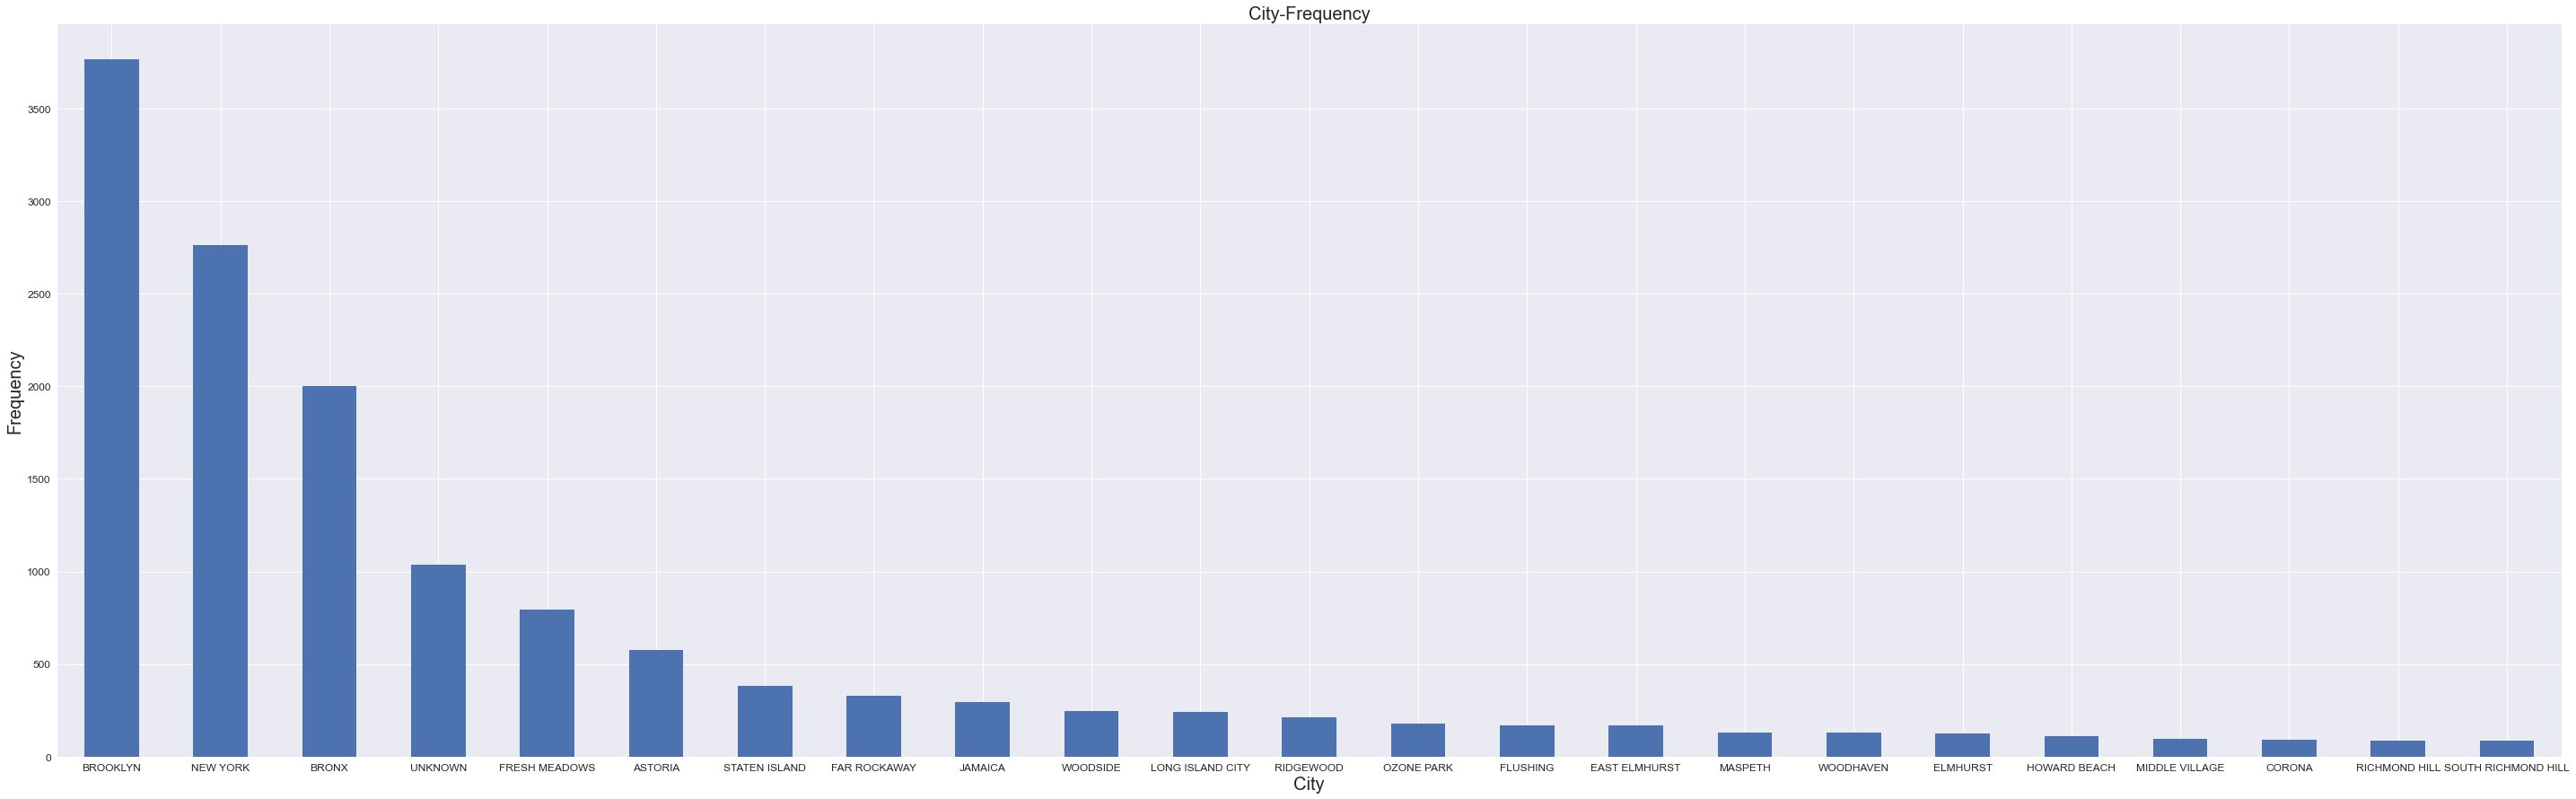

In [17]:
#We draw the first half cities firstly
draw(df[columns[0]], 'City', 'Frequency', 0, length // 2, fontsize=12)

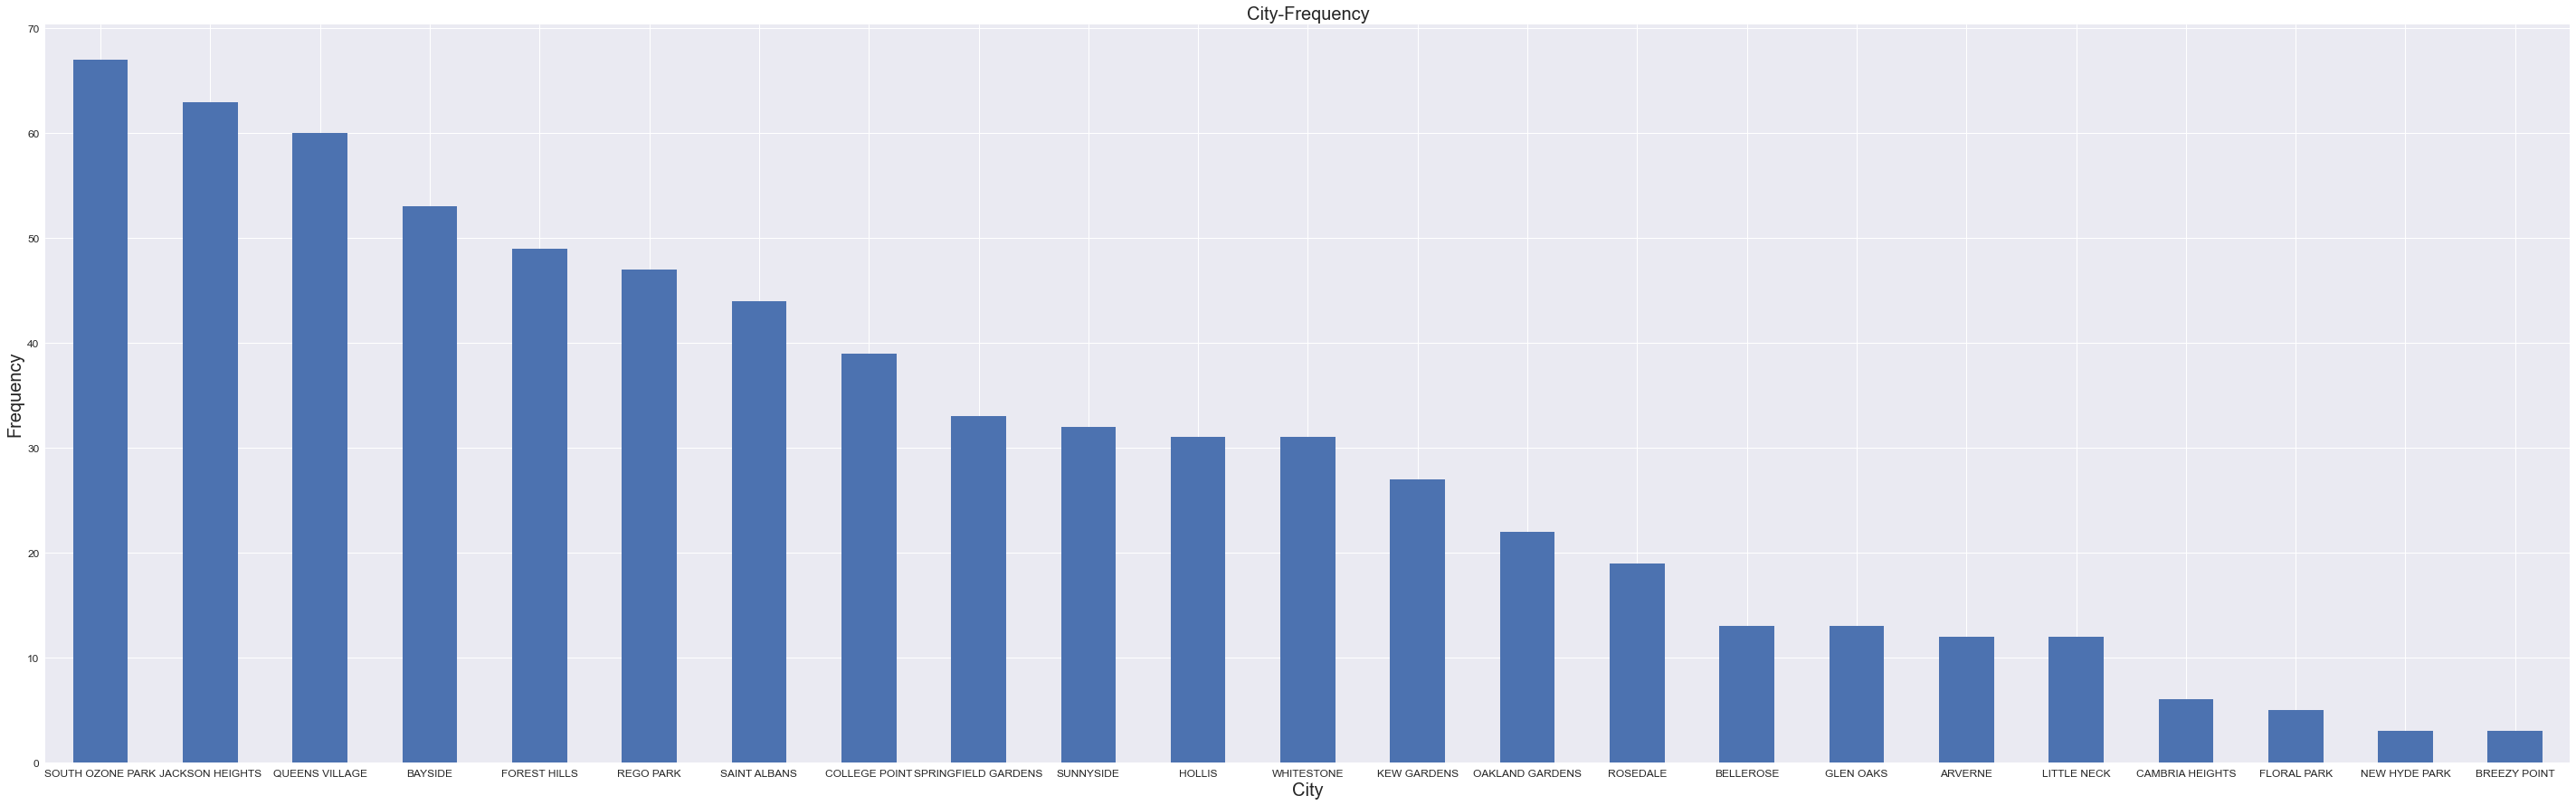

In [18]:
# We draw another half
draw(df[columns[0]], 'City', 'Frequency', length // 2, length, fontsize=12)

## For dataset DOB_NOW__Electrical_Permit_Applications.csv

In [19]:
df = pd.read_csv(root + files[1], low_memory=False)
print(df[columns[1]].value_counts())

BROOKLYN               80170
NEW YORK               29429
STATEN ISLAND          28269
BRONX                  23130
LONG ISLAND CITY       17630
FLUSHING               11677
ASTORIA                 8767
WOODSIDE                7390
JAMAICA                 4808
MASPETH                 4075
OZONE PARK              3868
SPRINGFIELD GARDENS     3462
RICHMOND HILL           2846
COLLEGE POINT           2558
QUEENS VILLAGE          2346
QUEENS                  2263
ST. ALBANS              2228
L.I.C.                  2104
WOODHAVEN               1973
MIDDLE VILLAGE          1391
WHITESTONE              1330
RIDGEWOOD               1272
ROCKAWAY PARK           1002
EAST ELMHURST            870
GLENDALE                 826
BAYSIDE                  727
JACKSON HEIGHTS          716
FAR ROCKAWAY             705
LIC                      576
SOUTH OZONE PARK         558
BELLEROSE                549
SOUTH RICHMOND HILL      497
CAMBRIA HEIGHTS          463
CORONA                   452
HOWARD BEACH  

In [20]:
df = refined_method(df, columns[1])
df.to_csv('../Resultset/city_res_2.csv')
length = len(df[columns[1]].value_counts())

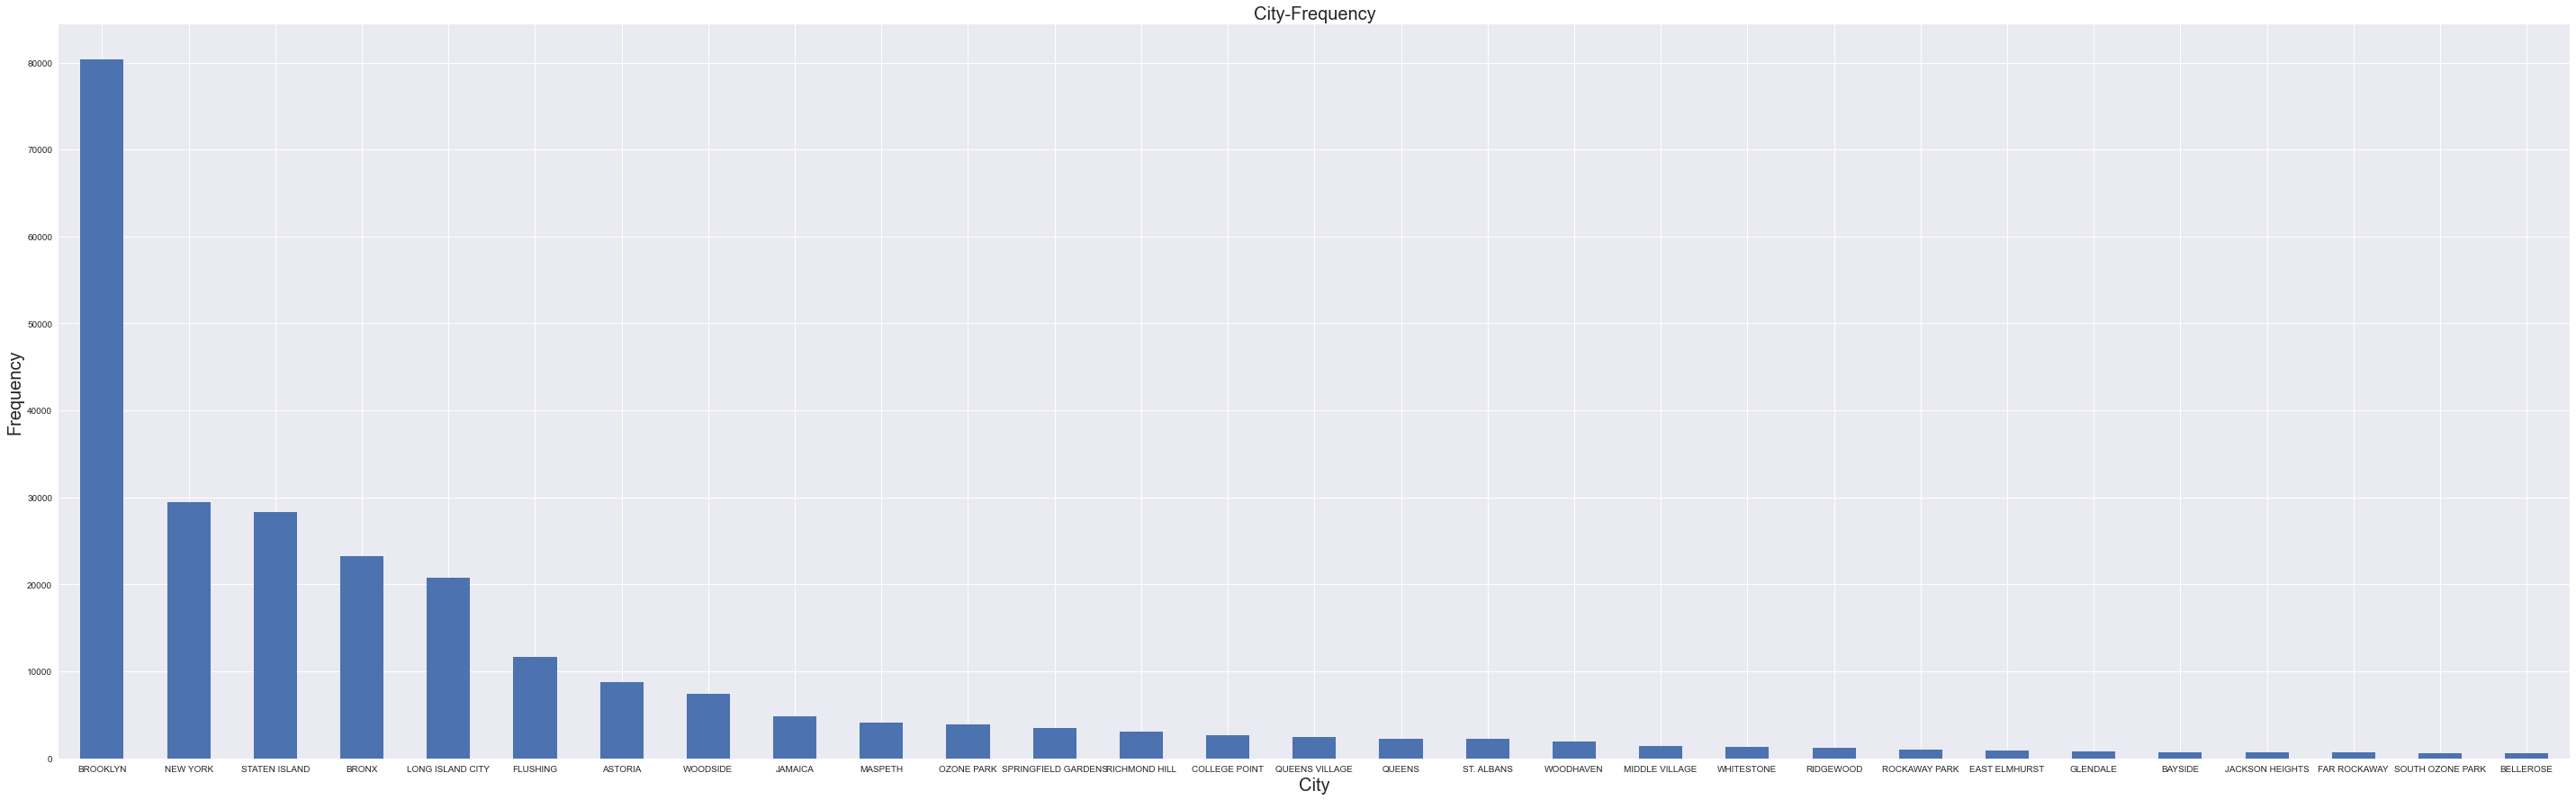

In [21]:
#We draw the first half cities firstly
draw(df[columns[1]], 'City', 'Frequency', 0, length // 2, fontsize=10)

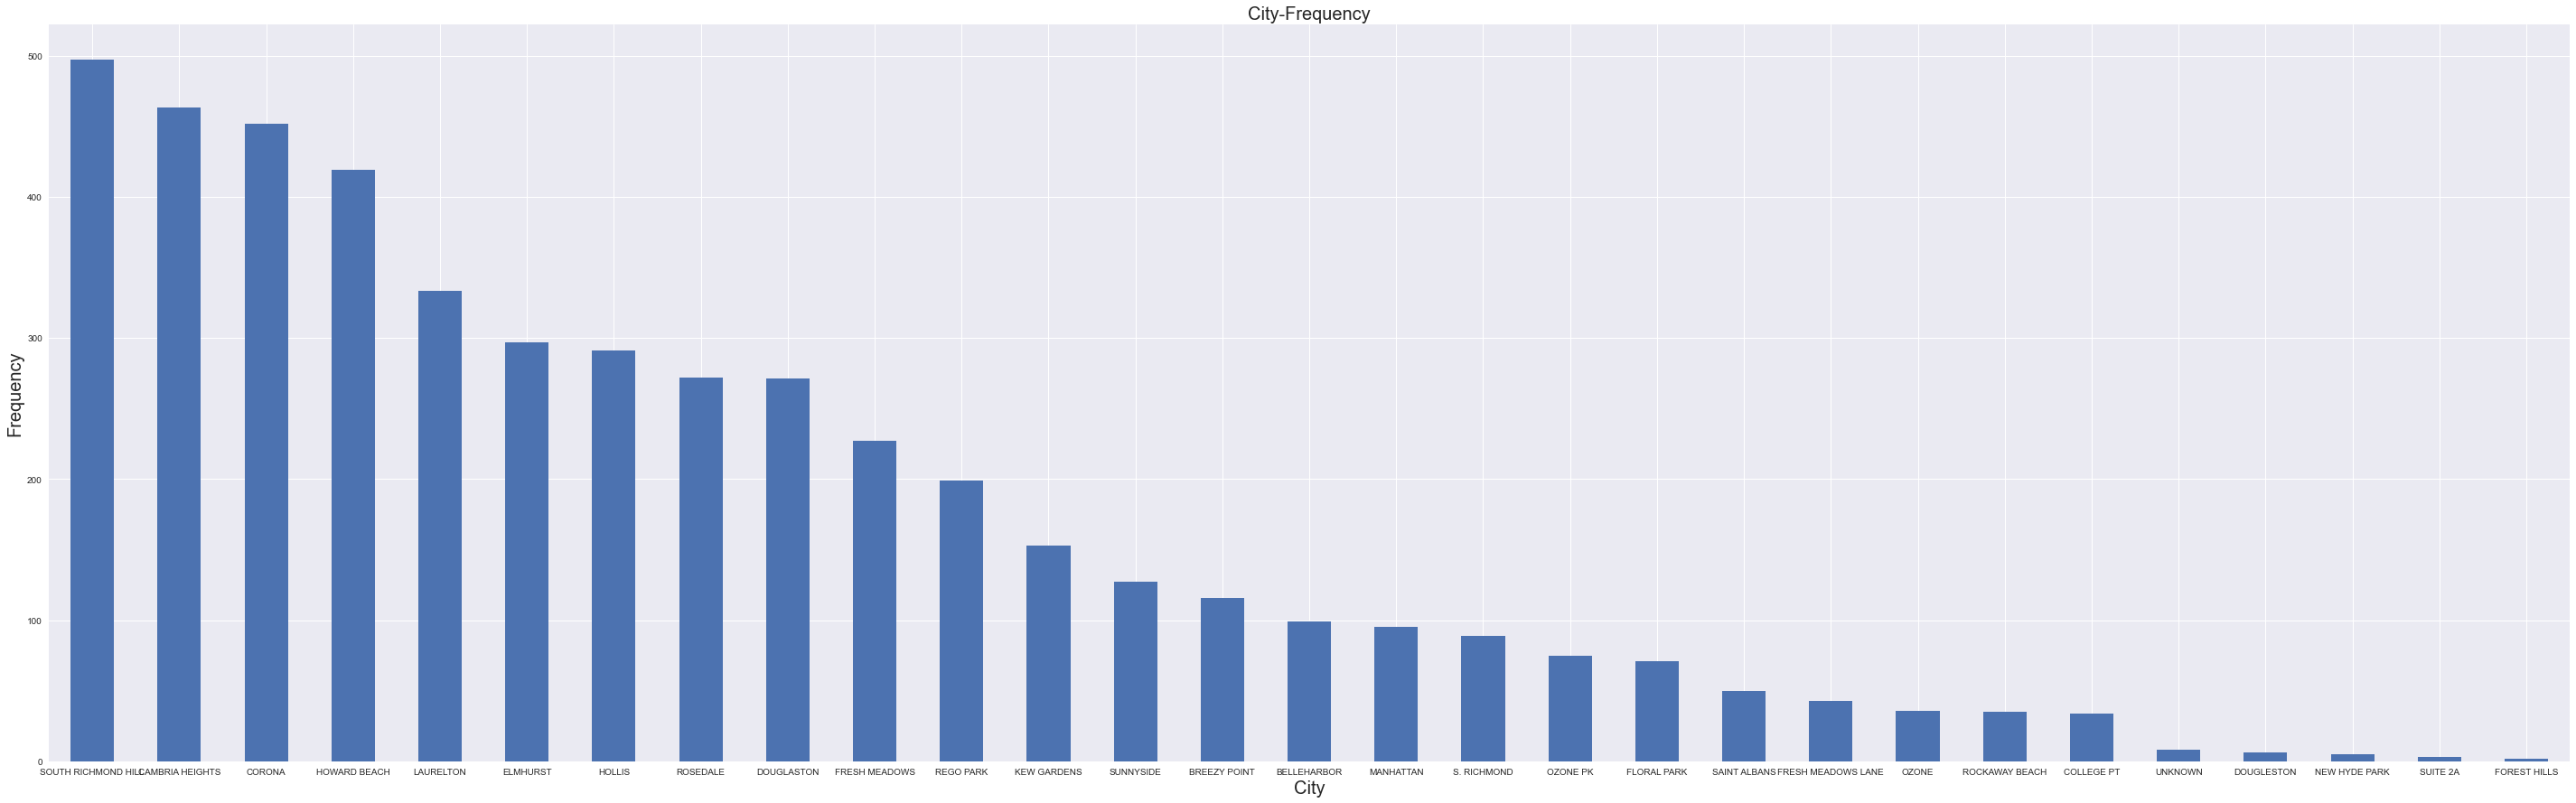

In [22]:
# We draw another half
draw(df[columns[1]], 'City', 'Frequency', length // 2, length, fontsize=10)

## For dataset DOB_Cellular_Antenna_Filings.csv

In [23]:
df = pd.read_csv(root + files[2], low_memory=False)
print(df[columns[2]].value_counts())

NEW YORK           1497
PARSIPPANY         1196
BROOKLYN            739
BEDMINSTER          409
BRONX               270
STATEN ISLAND       171
MASSAPEQUA          120
BLOOMFIELD          111
QUEENS               93
GREAT NECK           91
MORRISTOWN           74
FLUSHING             67
LONG ISLAND CIT      52
FOREST HILLS         48
JAMAICA              40
NEW ROCHELLE         39
BOCA RATON           33
ASTORIA              32
BAYSIDE              32
NY                   21
MANHASSET            21
NEWARK               18
PARSIPPANY,          18
RIDGEWOOD            18
WHITESTONE           17
REGO PARK            17
FLORAL PARK          15
LIC                  14
WOODMERE             14
SCARSDALE            13
ELMHURST             13
GLENDALE             13
OZONE PARK           13
MAHWAH               13
YONKERS              11
NEW HYDE PARK        11
MASPETH              11
CLIFTON PARK         10
WOODSIDE             10
DOUGLASTON           10
GLEN OAKS             9
RICHMOND HILL   

In [24]:
df = refined_method(df, columns[2])
df.to_csv('../Resultset/city_res_3.csv')
length = len(df[columns[2]].value_counts())

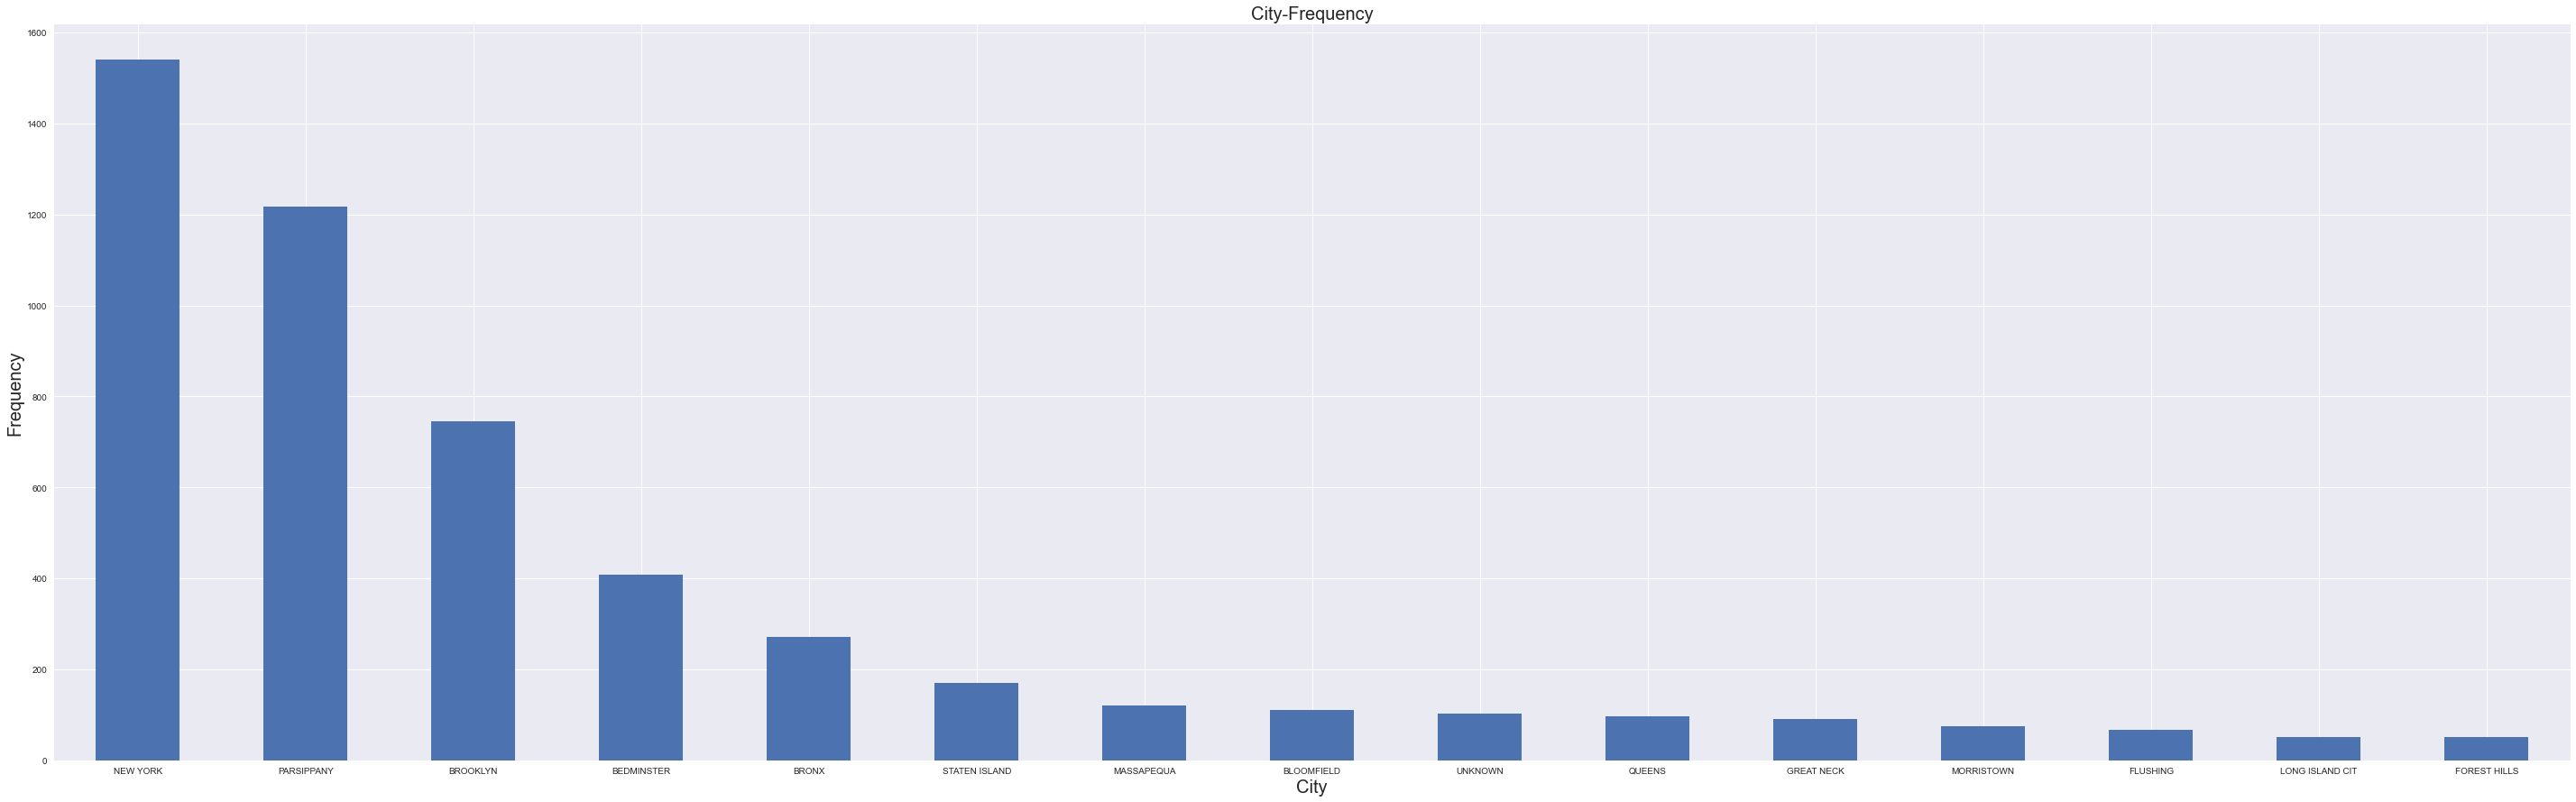

In [25]:
# Due to the size of the interface, we only draw the top 15 city names in terms of frequency here
draw(df[columns[2]], 'City', 'Frequency', 0, 15, fontsize=10)